# Single Replica TIS

This notebook shows how to run single replica TIS move scheme. This assumes you can load engine, network, and initial sample from a previous calculation.

In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np

In [2]:
from openpathsampling.visualize import PathTreeBuilder, PathTreeBuilder
from IPython.display import SVG, HTML

def ipynb_visualize(movevis):
    """Default settings to show a movevis in an ipynb."""
    view = movevis.renderer
    view.zoom = 1.5
    view.scale_y = 18
    view.scale_th = 20
    view.font_size = 0.4
    return view

Open the storage and load things from it.

In [3]:
old_store = paths.AnalysisStorage("mstis.nc")

In [4]:
network = old_store.networks[0]
engine = old_store.engines[0]
template = old_store.snapshots[0]

In [5]:
network.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
network.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }
rate = network.rate_matrix(old_store)

In [19]:
# TODO: add way to get the 
table = {}
for t in network.sampling_transitions:
    for ens, lambda_ens in zip(t.ensembles, [0.04, 0.09, 0.16]):
        table[ens] = t.tcp(lambda_ens)
for ens in network.special_ensembles['ms_outer'].keys():
    table[ens] = 0.25

In [20]:
bias = paths.BiasEnsembleTable(table)

In [21]:
print table

{<openpathsampling.ensemble.TISEnsemble object at 0x10b324650>: 0.80135768270578978, <openpathsampling.ensemble.TISEnsemble object at 0x10b324e90>: 0.067841576618034416, <openpathsampling.ensemble.TISEnsemble object at 0x10b3540d0>: 0.69506001846722065, <openpathsampling.ensemble.TISEnsemble object at 0x10b36d5d0>: 1.0, <openpathsampling.ensemble.UnionEnsemble object at 0x10b3289d0>: 0.25, <openpathsampling.ensemble.TISEnsemble object at 0x10b324fd0>: 0.13731064789861344, <openpathsampling.ensemble.TISEnsemble object at 0x10b35cb50>: 1.0, <openpathsampling.ensemble.TISEnsemble object at 0x10b35c790>: 0.27481094415835705, <openpathsampling.ensemble.TISEnsemble object at 0x10b3249d0>: 1.0585513491330665, <openpathsampling.ensemble.TISEnsemble object at 0x10b32b650>: 0.45892552976297252}


Here we actually set up the SRTIS move scheme for the given network. It only requires one line:

In [22]:
scheme = paths.SRTISScheme(network, bias)

Now we'll visualize the SRTIS move scheme.

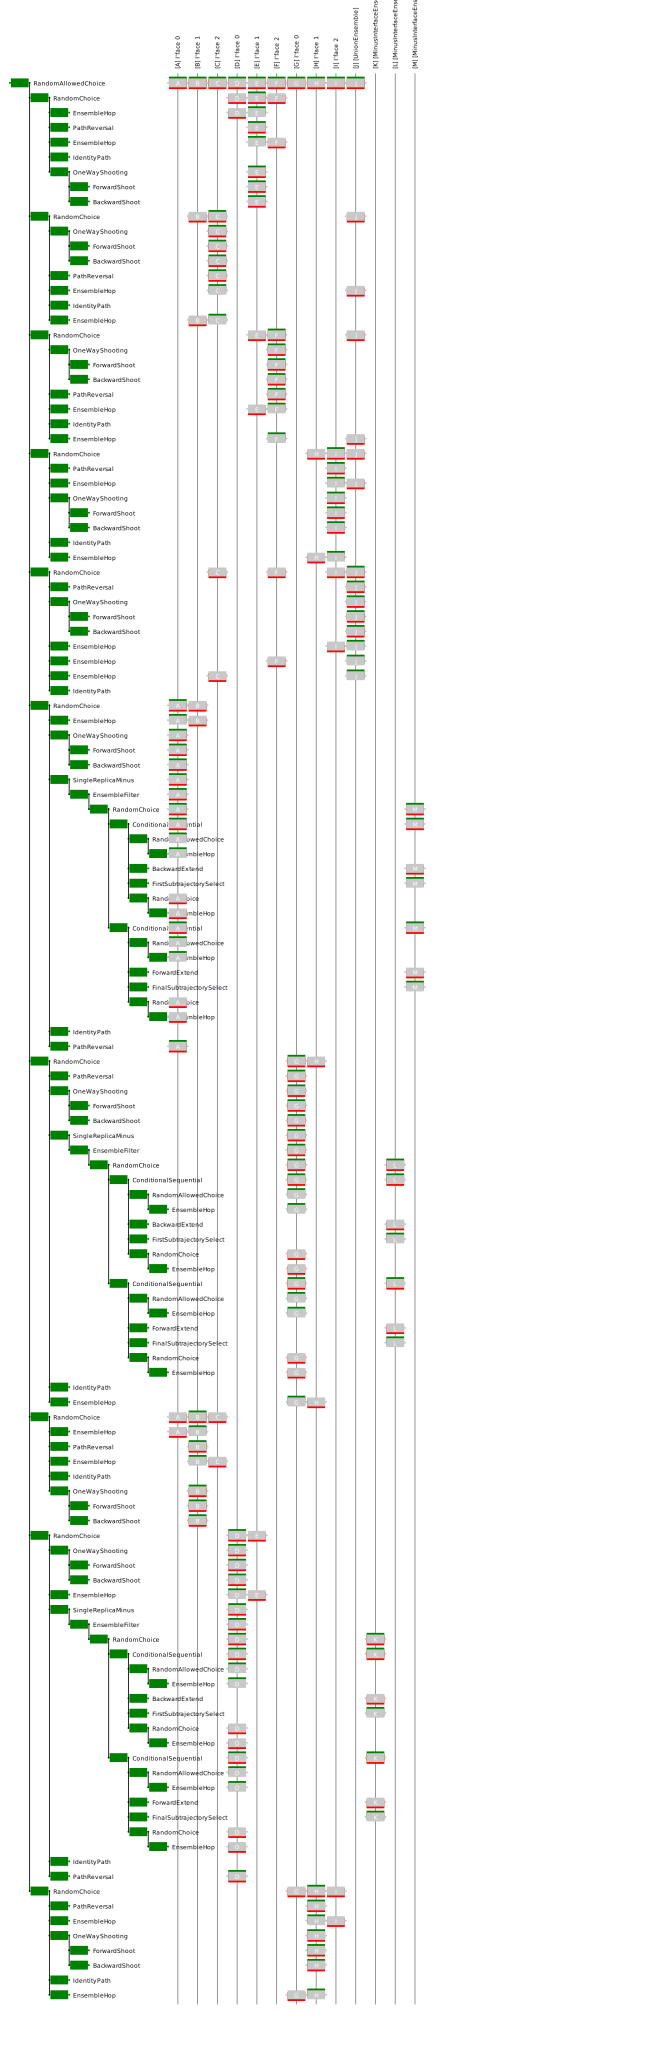

In [23]:
movevis = paths.visualize.MoveTreeBuilder()
movevis.mover(scheme.move_decision_tree(), network.all_ensembles)
SVG(ipynb_visualize(movevis).to_svg())

Next we need to set up an appropriate single-replica initial sample set. We'll take the last version of from one of the outer TIS ensembles.

In [24]:
final_samp0 = old_store.steps[len(old_store.steps)-1].active[network.sampling_ensembles[-1]]

In [25]:
sset = paths.SampleSet([final_samp0])

Finally, we set up the new storage file and the new simulation. 

In [26]:
storage = paths.Storage("srtis.nc", "w", template)

In [27]:
srtis = paths.PathSampling(
    storage=storage,
    globalstate=sset,
    engine=engine,
    move_scheme=scheme
)

In [28]:
n_steps_to_run = int(scheme.n_steps_for_trials(
        mover=scheme.movers['minus'][0], 
        n_attempts=2
    ))
print n_steps_to_run

2460


In [29]:
srtis.run_until(n_steps_to_run)

Working on Monte Carlo cycle number 2460.

DONE! Completed 2460 Monte Carlo cycles.



In [30]:
storage.close()
storage = paths.AnalysisStorage("srtis.nc")

In [31]:
scheme = storage.schemes[0]

In [32]:
scheme.move_summary(storage, 'shooting')

OneWayShootingMover I'face 1 ran 0.690776107273% of the cycles with acceptance 13/17 (0.764705882353)
OneWayShootingMover I'face 2 ran 0.0% of the cycles with acceptance 0/0 (nan)
OneWayShootingMover I'face 0 ran 0.0% of the cycles with acceptance 0/0 (nan)
OneWayShootingMover I'face 2 ran 0.0% of the cycles with acceptance 0/0 (nan)
OneWayShootingMover I'face 0 ran 0.0% of the cycles with acceptance 0/0 (nan)
OneWayShootingMover I'face 1 ran 0.0% of the cycles with acceptance 0/0 (nan)
OneWayShootingMover I'face 0 ran 2.88500609508% of the cycles with acceptance 53/71 (0.746478873239)
OneWayShootingMover I'face 1 ran 0.0% of the cycles with acceptance 0/0 (nan)
OneWayShootingMover I'face 2 ran 0.812677773263% of the cycles with acceptance 8/20 (0.4)


In [33]:
scheme.move_summary(storage, 'minus')

SingleReplicaMinus ran 0.446972775295% of the cycles with acceptance 11/11 (1.0)
SingleReplicaMinus ran 0.0% of the cycles with acceptance 0/0 (nan)
SingleReplicaMinus ran 0.0% of the cycles with acceptance 0/0 (nan)


In [34]:
scheme.move_summary(storage, 'repex')

EnsembleHop ran 0.0% of the cycles with acceptance 0/0 (nan)
EnsembleHop ran 0.0% of the cycles with acceptance 0/0 (nan)
EnsembleHop ran 0.0% of the cycles with acceptance 0/0 (nan)
EnsembleHop ran 0.0% of the cycles with acceptance 0/0 (nan)
EnsembleHop ran 0.0406338886631% of the cycles with acceptance 1/1 (1.0)
EnsembleHop ran 0.365704997968% of the cycles with acceptance 9/9 (1.0)
EnsembleHop ran 0.0% of the cycles with acceptance 0/0 (nan)
EnsembleHop ran 0.975213327915% of the cycles with acceptance 8/24 (0.333333333333)
EnsembleHop ran 0.0% of the cycles with acceptance 0/0 (nan)
EnsembleHop ran 0.0% of the cycles with acceptance 0/0 (nan)
EnsembleHop ran 0.0% of the cycles with acceptance 0/0 (nan)
EnsembleHop ran 0.853311661926% of the cycles with acceptance 10/21 (0.47619047619)
EnsembleHop ran 0.0% of the cycles with acceptance 0/0 (nan)
EnsembleHop ran 0.446972775295% of the cycles with acceptance 11/11 (1.0)
EnsembleHop ran 0.0% of the cycles with acceptance 0/0 (nan)
Ens

In [35]:
scheme.move_summary(storage)

ms_outer_shooting ran 0.0% of the cycles with acceptance 0/0 (nan)
repex ran 2.92563998375% of the cycles with acceptance 40/72 (0.555555555556)
shooting ran 4.38845997562% of the cycles with acceptance 74/108 (0.685185185185)
minus ran 0.446972775295% of the cycles with acceptance 11/11 (1.0)
pathreversal ran 1.99106054449% of the cycles with acceptance 48/49 (0.979591836735)
